In [2]:
##### base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)

# explainability
# import shap, lime #eli5
# shap.initjs()

# debug
# from icecream import ic
# debug = ic
import logging
logg = logging.info

In [3]:
import os, sys, re
import argparse
import time
import random
import logging

from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from torch._C import device
from torch.utils.data import DataLoader
import torch

from modules.train import train
from modules.test import test
from modules.loader import CustomBamDataset2
import utils.utils as util
from utils.utils import Parms

In [4]:
parser = argparse.ArgumentParser('Train or test SomaticSerum model.')
parser.add_argument('training_bam_dir', type=str,
                    help='Train data bams directory')
parser.add_argument('--sample_split', required=False, type=str,
                    help='How to split the training data: True - by samples, False - by random on the entire dataset',
                    default = 'True')
parser.add_argument('--model', required=False, type=str, 
                    help='model', default='SimpleCnn')
parser.add_argument('--hidden_size', required=False, type=int,
                    help='The number of hidden units', default=64)
parser.add_argument('--sequence_length', required=False, type=int,
                    help='The length of the sequence', default=200)
parser.add_argument('--batch_size', required=False, type=int,
                    help='The size of each batch', default=512)
parser.add_argument('--learning_rate', required=False, type=float,
                    help='The learning rate value', default=0.00001)
parser.add_argument('--max_epoch', required=False, type=int,
                    help='The maximum epoch', default=100)
parser.add_argument('--lstm_layers', required=False, type=int,
                    help='Num of LSTM layers', default=10)
parser.add_argument('--dropout', required=False, type=float,
                    help='Dropout', default=0.5)
parser.add_argument('--num_workers', required=False, type=int,
                    help='Number of workers', default=1)
parser.add_argument('--out', required=False, type=str,
                    help='Output directory', default='output')
parser.add_argument('--test', required=False, type=str,
                    help='Test directory')
# args = parser.parse_args()

args = parser.parse_known_args()[0]
args.__dict__.update(dict(
#         training_bam_dir="../data/seqmerge/DLbams_rand",
#         training_bam_dir='/data/alonwolf/projects/SomaticSerum/data/seqmerge/DLbams_rand',
        training_bam_dir='/data/alonwolf/projects/SomaticSerum/data/sample',
#         training_bam_dir='/data/alonwolf/projects/SomaticSerum/data/seqmerge/DLbams',
        sample_split=True,
        model="metaSimpleDense",
        hidden_size=64,
        batch_size=32,
        learning_rate=0.001,
        max_epoch=20,
        dropout=0.005,
#         out=MassiveLoop3,
    ))
parms = Parms(
    args
)

root        : INFO     Logger initialized


In [5]:
from modules.loader import CustomBamDataset2
full_train_dataset  = CustomBamDataset2(parms.BAM_DIR, out = parms.OUT, whichSet = 'train', force = True)
train_size          = int(parms.TRAIN_VALIDATION_SPLIT * len(full_train_dataset))
val_size            = len(full_train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

root        : INFO     Dataloading train
root        : INFO     Longest read: 683
root        : INFO     Loading reads from: somatic_reads.LUAD02.SNVs.srt.bam 		bam file number 0
root        : INFO     Loading reads from: normal_reads.LUAD02.SNVs.srt.bam 		bam file number 1
root        : INFO     Number of Normal reads: 2389, Number of Somatic reads: 2621. Ratio: 0.911


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size = parms.BATCH_SIZE, shuffle = True, num_workers = parms.NUM_WORKERS)
valid_dataloader = DataLoader(valid_dataset, batch_size = parms.BATCH_SIZE, shuffle = True, num_workers = parms.NUM_WORKERS)

In [7]:
def torch_ds_to_numpy(ds):
    sample_dataloader = DataLoader(ds, batch_size = len(ds), shuffle = True, num_workers = 1)
    for batch in sample_dataloader:
        break
    return [df.numpy() for df in batch]

x_dna, x_att, y = torch_ds_to_numpy(train_dataset)
x_dna.shape, x_att.shape, y.shape

((4008, 3, 200), (4008, 12), (4008,))

In [8]:
# # --- Model setup ----------------------------------------------------
# logging.info('Setting up the model...')
# nucleotide_model    = parms.return_model(meta_dim = x_att.shape[1])
# loss_fn             = torch.nn.CrossEntropyLoss()
# model_params        = list(nucleotide_model.parameters())
# optimizer           = torch.optim.AdamW(model_params, lr=parms.LEARNING_RATE, eps=1e-08, weight_decay=0.01)


# # --- Training -------------------------------------------------------
# logging.info('Setting up the model...')
# if torch.cuda.is_available():
#     nucleotide_model = nucleotide_model.cuda()
#     device = 'cuda'
# else:
#     device = 'cpu'
# logg(device)

# if parms.TEST:
#     # Skip training
#     logging.info('Skipping train')
#     metric = pd.read_csv('{}/metric.csv'.format(parms.TEST))
#     name = '{}/{}'.format(parms.TEST, [f for f in os.listdir(parms.TEST) if f.endswith('.txt')][0].split('txt')[0])
#     model_path = "{}/{}.pth".format(parms.TEST, type(nucleotide_model).__name__)
#     metric_test = test(parms, model_path, test_dataloader, device, loss_fn)
# else:
#     logging.info('Training...')
#     history, name, metric, model_path = train(model = nucleotide_model,
#                                 optimizer = optimizer,
#                                 loss_fn = loss_fn,
#                                 train_dl = train_dataloader,
#                                 val_dl = valid_dataloader,
#                                 epochs = parms.MAX_EPOCH,
#                                 device = device,
#                                 out = parms.OUT)
#     # Test
#     metric_test = test(parms, model_path, valid_dataloader, device, loss_fn)

# # --- Plotting -------------------------------------------------------
# logging.info('Plotting...')
# util.plot(name, metric, metric_test, parms.OUT)

# acc = history['acc']
# val_acc = history['val_acc']
# loss = history['loss']
# val_loss = history['val_loss']
# epochs = range(1, len(acc) + 1)

# logging.info("Done!")

In [350]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

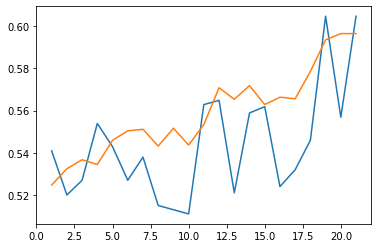

In [351]:
plt.plot(epochs, val_acc)
plt.plot(epochs, acc)

In [352]:
nucleotide_model.forward(torch.Tensor(x_dna[[5],:]), torch.Tensor(x_att[[5],:]))[0][0].detach().numpy()

array(0.44627097, dtype=float32)

In [9]:
len(train_dataset)

4008

In [10]:
np.histogram(x[y==0])

NameError: name 'x' is not defined

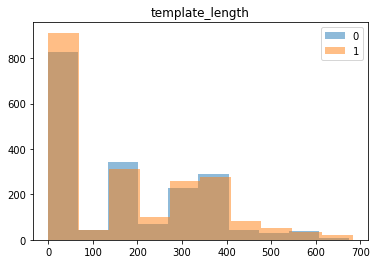

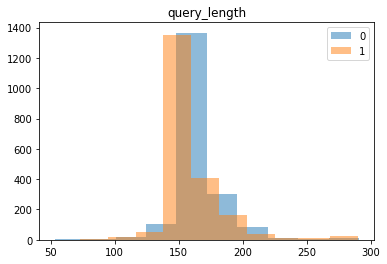

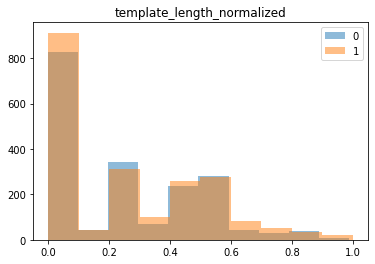

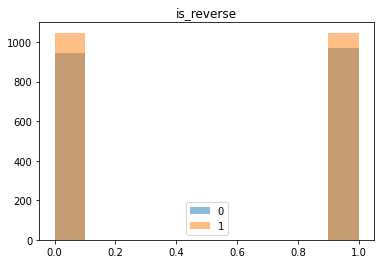

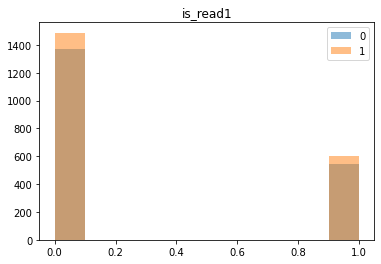

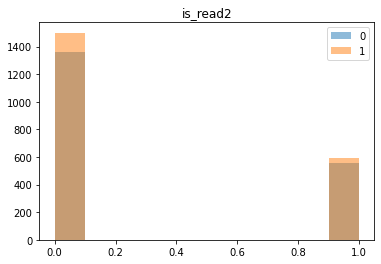

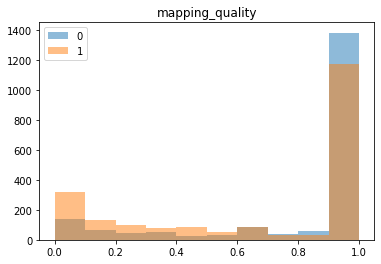

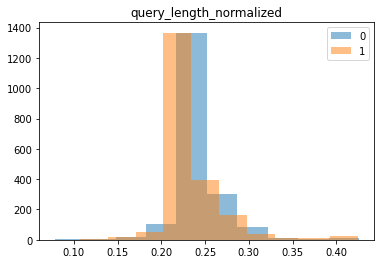

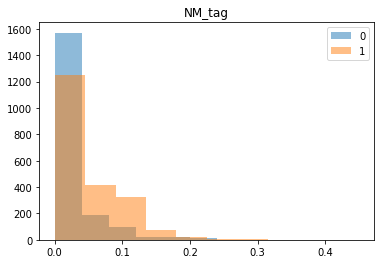

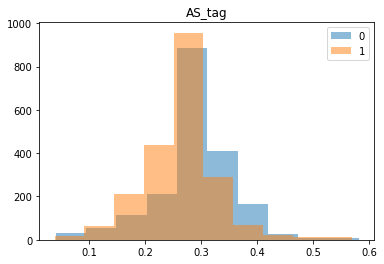

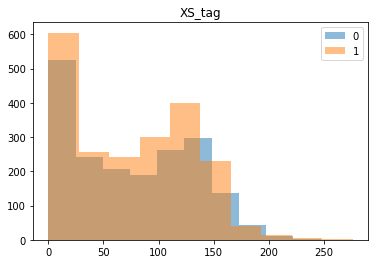

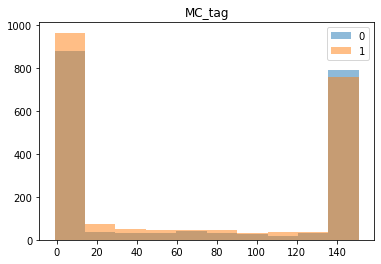

In [11]:
def print_feature(x,y,title = None):
    if title: plt.title(title) 
    for label in [0,1]:
        plt.hist(x[y==label], alpha = 0.5, label = label)
    plt.legend()
    plt.show()

def save_feature_histogram(x,y, title):
    hist_0, bin_edges_0 = np.histogram(x[y==0])
    hist_1, bin_edges_1 = np.histogram(x[y==1])
    pd.DataFrame({
        'bins_healthy': bin_edges_0[1:],
        'hist_healthy': hist_0,
        'bins_somatic': bin_edges_1[1:],
        'hist_somatic': hist_1
    }
    ).to_excel(PLOTS_DIR / f"histogram__{title}.xlsx")
    
titles = [
    'template_length',
    'query_length',
    'template_length_normalized',
    'is_reverse',
    'is_read1',
    'is_read2',
    'mapping_quality',
    'query_length_normalized',
    'NM_tag',
    'AS_tag',
    'XS_tag',
    'MC_tag'
]
for i in range(x_att.shape[1]):
    print_feature(x_att[:,i], y, title=titles[i])

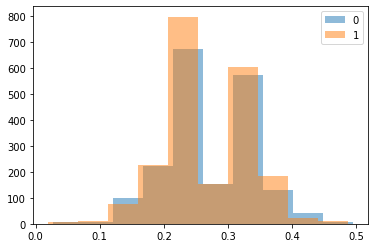

In [12]:
feat = x_dna[:,1]
feat[feat<0] = 0
feat = feat.mean(axis = 1)
print_feature(feat, y)

(array([1915.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2093.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

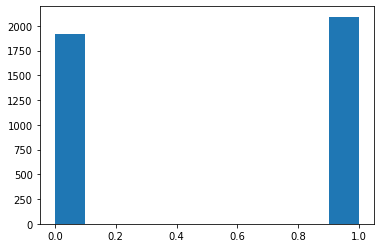

In [13]:
plt.hist(y)

In [14]:
x_dna[:,1]

array([[0.312, 0.258, 0.312, ..., 0.   , 0.   , 0.   ],
       [0.323, 0.301, 0.312, ..., 0.   , 0.   , 0.   ],
       [0.312, 0.323, 0.301, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.323, 0.29 , 0.323, ..., 0.   , 0.   , 0.   ],
       [0.312, 0.301, 0.312, ..., 0.   , 0.   , 0.   ],
       [0.043, 0.108, 0.097, ..., 0.   , 0.   , 0.   ]], dtype=float32)

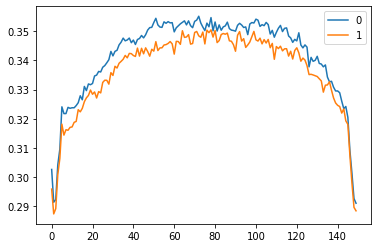

In [15]:
quals = x_dna[:,1]
quals[quals<0] = 0
plt.plot(quals[y == 0].mean(axis = 0)[:150], label = 0)
plt.plot(quals[y == 1].mean(axis = 0)[:150],label = 1)
plt.xlabel('')

plt.legend()
plt.show()


In [16]:
# pd.DataFrame({
#     'bp': np.arange(150),
#     'somatic': quals[y == 1].mean(axis = 0)[:150],
#     'healthy': quals[y == 0].mean(axis = 0)[:150]
# }).to_excel(PLOTS_DIR / 'quality_comparison_LUAD02.xlsx')

In [17]:
quals = x_dna[:,1]#.mean(axis=1)
x = np.hstack([x_att, quals.mean(axis=1).reshape(-1,1)])
x.shape

(4008, 13)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [19]:
from models import *
# clf = LogisticModel(max_iter = 1000, C=0.8)

# clf = LGBMModel(n_estimators=10, max_depth=5, colsample_bytree=0.2)

# clf = XGBModel(n_estimators=30, max_depth=5, colsample_bytree=0.8)

# clf = SkorchModel(n_features)

# clf = KerasModel()

2022-06-28 19:10:57.597762: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-28 19:10:57.612238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 19:10:57.612278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
from models.torch import TorchModel

In [21]:
from modules.models import metaSimpleDense

In [22]:
from models.torch import TorchModel
from modules.models import metaSimpleDense

clf = TorchModel(metaSimpleDense(input_size=x_train.shape[1], hidden_size = 5))

In [23]:
from sklearn.metrics import f1_score, accuracy_score
from utils.metric_utils import HardMetric
final_metric = HardMetric(f1_score)

In [24]:
x_train = pd.DataFrame(x_train)
y_train = pd.Series(y_train)

clf.fit(x_train, y_train, learning_rate=0.002, epochs=30)

root        : INFO     Epoch   1/ 30, train loss: 0.0217, train acc: 0.5210
root        : INFO     Epoch   2/ 30, train loss: 0.0216, train acc: 0.5210
root        : INFO     Epoch   3/ 30, train loss: 0.0216, train acc: 0.5210
root        : INFO     Epoch   4/ 30, train loss: 0.0216, train acc: 0.5210
root        : INFO     Epoch   5/ 30, train loss: 0.0216, train acc: 0.5210
root        : INFO     Epoch   6/ 30, train loss: 0.0216, train acc: 0.5289
root        : INFO     Epoch   7/ 30, train loss: 0.0216, train acc: 0.5273
root        : INFO     Epoch   8/ 30, train loss: 0.0216, train acc: 0.5346
root        : INFO     Epoch   9/ 30, train loss: 0.0216, train acc: 0.5329
root        : INFO     Epoch  10/ 30, train loss: 0.0216, train acc: 0.5343
root        : INFO     Epoch  11/ 30, train loss: 0.0216, train acc: 0.5353
root        : INFO     Epoch  12/ 30, train loss: 0.0216, train acc: 0.5336
root        : INFO     Epoch  13/ 30, train loss: 0.0216, train acc: 0.5353
root        

In [104]:
# from models import *

# x_train = pd.DataFrame(x_train)
# y_train = pd.Series(y_train)

# from models.optuna import OptunaCV
# clf = OptunaCV.optimize(
#     x_train,
#     y_train,
#     estimators= [XGBModel, LGBMModel, KerasModel],
#     metric=final_metric,
#     n_trials = 100
# )

[I 2022-06-21 13:44:04,482] A new study created in memory with name: no-name-6ab7a9e4-83db-4504-97c2-b737bb34a791
2022-06-21 13:44:04.490690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-21 13:44:04.490739: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 13:44:04.490766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-0-1): /proc/driver/nvidia/version does not exist
2022-06-21 13:44:04.491363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appro

29/29 [==============================] - 0s 1ms/step


[I 2022-06-21 13:44:06,245] Trial 0 finished with value: 0.40590405904059046 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 12, 'epochs': 19, 'batch_size': 37}. Best is trial 0 with value: 0.40590405904059046.
[I 2022-06-21 13:44:06,782] Trial 1 finished with value: 0.7811934900542497 and parameters: {'classifier': <class 'models.xgboost.XGBModel'>, 'booster': 'dart', 'lambda': 0.022108652682911546, 'alpha': 0.0012046790470726318, 'n_estimators': 13, 'max_depth': 2, 'eta': 4.73319510378416e-08, 'gamma': 0.01075734682459336, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0018173779269316018, 'skip_drop': 7.217466975396236e-05}. Best is trial 1 with value: 0.7811934900542497.
[I 2022-06-21 13:44:08,992] Trial 2 finished with value: 0.7974568574023615 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 238, 'lambda_l1': 6.387502349023922, 'lambda_l2': 1.2242239409103597e-08, 'num_

29/29 [==============================] - 0s 2ms/step


[I 2022-06-21 13:44:13,061] Trial 5 finished with value: 0.44765342960288806 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 15, 'epochs': 24, 'batch_size': 46}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:13,811] Trial 6 finished with value: 0.7770382695507486 and parameters: {'classifier': <class 'models.xgboost.XGBModel'>, 'booster': 'dart', 'lambda': 0.0001318004929541503, 'alpha': 9.056393433996491e-08, 'n_estimators': 30, 'max_depth': 9, 'eta': 0.013865521872339673, 'gamma': 2.517472324816178e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.1581991207519e-08, 'skip_drop': 1.8206807761009734e-08}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:15,207] Trial 7 finished with value: 0.7724770642201835 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 279, 'lambda_l1': 0.0001038953629266621, 'lambda_l2': 1.800876471375333, 'num_le

29/29 [==============================] - 0s 2ms/step


[I 2022-06-21 13:44:16,421] Trial 8 finished with value: 0.6230636833046471 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 7, 'epochs': 17, 'batch_size': 61}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:17,430] Trial 9 finished with value: 0.7964912280701755 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 144, 'lambda_l1': 6.07400029917765e-06, 'lambda_l2': 6.055677626283108e-08, 'num_leaves': 143, 'feature_fraction': 0.4753956545639374, 'bagging_fraction': 0.5679657341733727, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:19,577] Trial 10 finished with value: 0.7649769585253455 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 199, 'lambda_l1': 8.702319917405191, 'lambda_l2': 0.000720086551633825, 'num_leaves': 249, 'feature_fraction': 0.856736923081384, 'bagging_fraction': 0.9831223935165376, 'bagging_fr

29/29 [==============================] - 0s 1ms/step


[I 2022-06-21 13:44:32,270] Trial 18 finished with value: 0.6671698113207547 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 31, 'epochs': 3, 'batch_size': 16}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:33,138] Trial 19 finished with value: 0.0 and parameters: {'classifier': <class 'models.xgboost.XGBModel'>, 'booster': 'gblinear', 'lambda': 2.1173188691482335e-08, 'alpha': 0.3230428949764759, 'n_estimators': 143}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:34,821] Trial 20 finished with value: 0.7870036101083032 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 246, 'lambda_l1': 0.0001494674673611372, 'lambda_l2': 2.2516470941057126e-05, 'num_leaves': 53, 'feature_fraction': 0.558115360115133, 'bagging_fraction': 0.5957939872924226, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 2 with value: 0.7974568574023615.
[I 2022-06-21 13:44:35,966] Trial 21 finished with v

29/29 [==============================] - 0s 2ms/step


[I 2022-06-21 13:44:45,832] Trial 29 finished with value: 0.6430921052631579 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 29, 'epochs': 31, 'batch_size': 16}. Best is trial 22 with value: 0.8083682008368201.


29/29 [==============================] - 0s 1ms/step


[I 2022-06-21 13:44:46,920] Trial 30 finished with value: 0.4869976359338061 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 2, 'epochs': 3, 'batch_size': 62}. Best is trial 22 with value: 0.8083682008368201.
[I 2022-06-21 13:44:48,535] Trial 31 finished with value: 0.7961538461538462 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 181, 'lambda_l1': 1.9678952465226327, 'lambda_l2': 1.2553124563511473e-07, 'num_leaves': 170, 'feature_fraction': 0.8010905233744035, 'bagging_fraction': 0.4333131637136805, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 22 with value: 0.8083682008368201.
[I 2022-06-21 13:44:49,923] Trial 32 finished with value: 0.8034782608695651 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 128, 'lambda_l1': 0.0015012996197015778, 'lambda_l2': 9.752324897515019e-08, 'num_leaves': 192, 'feature_fraction': 0.5538023130474785, 'bagging_fraction': 0.8417701930588256, 'ba

29/29 [==============================] - 0s 1ms/step


[I 2022-06-21 13:45:00,561] Trial 40 finished with value: 0.6540284360189573 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 23, 'epochs': 11, 'batch_size': 34}. Best is trial 22 with value: 0.8083682008368201.
[I 2022-06-21 13:45:01,494] Trial 41 finished with value: 0.7936802973977695 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 90, 'lambda_l1': 2.1035075483456307, 'lambda_l2': 1.089700918329457e-08, 'num_leaves': 173, 'feature_fraction': 0.6025597232592375, 'bagging_fraction': 0.9435285549674914, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 22 with value: 0.8083682008368201.
[I 2022-06-21 13:45:02,117] Trial 42 finished with value: 0.776470588235294 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 27, 'lambda_l1': 1.2044124145705981, 'lambda_l2': 5.7311069677977746e-08, 'num_leaves': 190, 'feature_fraction': 0.764132815302131, 'bagging_fraction': 0.8949541674828403, 'bagging

29/29 [==============================] - 0s 2ms/step


[I 2022-06-21 13:45:32,943] Trial 57 finished with value: 0.6212121212121211 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 22, 'epochs': 32, 'batch_size': 46}. Best is trial 50 with value: 0.8123924268502581.
[I 2022-06-21 13:45:35,407] Trial 58 finished with value: 0.8041237113402061 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 157, 'lambda_l1': 4.242236518652792e-05, 'lambda_l2': 2.346788220855651, 'num_leaves': 239, 'feature_fraction': 0.5205436980251472, 'bagging_fraction': 0.5449335917850234, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 50 with value: 0.8123924268502581.
[I 2022-06-21 13:45:36,345] Trial 59 finished with value: 0.8185053380782918 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 157, 'lambda_l1': 9.822872256921421e-05, 'lambda_l2': 0.10860897714416365, 'num_leaves': 236, 'feature_fraction': 0.51697278247377, 'bagging_fraction': 0.6347678021734067, 'baggin

29/29 [==============================] - 0s 1ms/step


[I 2022-06-21 13:45:51,006] Trial 68 finished with value: 0.6629392971246008 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 21, 'epochs': 9, 'batch_size': 27}. Best is trial 59 with value: 0.8185053380782918.
[I 2022-06-21 13:45:59,006] Trial 69 finished with value: 0.7968056787932565 and parameters: {'classifier': <class 'models.xgboost.XGBModel'>, 'booster': 'dart', 'lambda': 0.0044746826722483, 'alpha': 1.836290165654727e-06, 'n_estimators': 259, 'max_depth': 5, 'eta': 0.8708150974104629, 'gamma': 2.0795358880469818e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4529637529266406, 'skip_drop': 0.3376051149427425}. Best is trial 59 with value: 0.8185053380782918.
[I 2022-06-21 13:46:03,120] Trial 70 finished with value: 0.7934027777777778 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 185, 'lambda_l1': 8.200475020358436e-05, 'lambda_l2': 0.0016964802718235127, 'num_le

29/29 [==============================] - 0s 2ms/step


[I 2022-06-21 13:46:25,996] Trial 86 finished with value: 0.6824925816023738 and parameters: {'classifier': <class 'models.keras.KerasModel'>, 'n_hidden': 8, 'epochs': 27, 'batch_size': 52}. Best is trial 59 with value: 0.8185053380782918.
[I 2022-06-21 13:46:26,784] Trial 87 finished with value: 0.6927536231884058 and parameters: {'classifier': <class 'models.xgboost.XGBModel'>, 'booster': 'gblinear', 'lambda': 0.6843081797278346, 'alpha': 0.0027029131981792377, 'n_estimators': 107}. Best is trial 59 with value: 0.8185053380782918.
[I 2022-06-21 13:46:27,849] Trial 88 finished with value: 0.7737355811889972 and parameters: {'classifier': <class 'models.lgbm.LGBMModel'>, 'n_estimators': 150, 'lambda_l1': 0.0007252753974098141, 'lambda_l2': 1.0104095573877398e-08, 'num_leaves': 30, 'feature_fraction': 0.9920497938599859, 'bagging_fraction': 0.4170402309692958, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 59 with value: 0.8185053380782918.
[I 2022-06-21 13:46:31,941] Trial 

0.8185053380782918


In [25]:
from models.skorch import SkorchModel
from modules.models import SimpleCnn, nucSimpleCnnOrig, metaSimpleDense
clf = SkorchModel(metaSimpleDense(input_size=x_train.shape[1], hidden_size = 5), optimizer__lr=0.005)

In [26]:
# from sklearn.svm import SVC
# # clf = SVC(probability=True)

# from xgboost import XGBClassifier
# clf = XGBClassifier()

In [28]:
clf.fit(x_train, y_train, epochs=400)
y_pred = clf.predict_proba(pd.DataFrame(x_test))[:,1]

ValueError: Expected module output to have shape (n,) or (n, 1), got (128, 2) instead

In [334]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for th in np.arange(20)/20:
    print(f'''at {th} acc is {np.round(accuracy_score(y_test, (y_pred > th)),2)} prec is {np.round(precision_score(y_test, (y_pred > th)),2)} rec is {np.round(recall_score(y_test, (y_pred > th)),2)} f1_score is {np.round(f1_score(y_test, (y_pred > th)),2)}''')

at 0.0 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.05 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.1 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.15 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.2 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.25 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.3 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.35 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.4 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.45 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.5 acc is 0.51 prec is 0.52 rec is 0.96 f1_score is 0.67
at 0.55 acc is 0.52 prec is 0.63 rec is 0.18 f1_score is 0.28
at 0.6 acc is 0.52 prec is 0.69 rec is 0.14 f1_score is 0.23
at 0.65 acc is 0.52 prec is 0.73 rec is 0.11 f1_score is 0.2
at 0.7 acc is 0.49 prec is 0.86 rec is 0.01 f1_score is 0.02
at 0.75 acc is 0.48 prec is 0.0 rec is 0.0 f1_score is 0.0
at 0.8 acc is 0.48 prec is 0.0

In [114]:
from config import PLOTS_DIR

from sklearn.metrics import precision_recall_curve, roc_curve
def save_curve_to_xlsx(f_curve, y_test, y_pred, x_name='x', y_name='y'):
    f_curve = roc_curve
    x, y, thresholds = f_curve(y_test, y_pred)
    if len(thresholds) < len(y):
        thresholds = np.pad(thresholds, pad_width=(1,0))
    pd.DataFrame({
        x_name: x,
        y_name: y,
        'thresholds': thresholds
    }).to_excel(PLOTS_DIR / f'{f_curve.__name__}_{str(clf).split("(")[0]}.xlsx')
# save_curve_to_xlsx(precision_recall_curve,y_test, y_pred,'prec','recall')
# save_curve_to_xlsx(roc_curve,y_test, y_pred,'fpr', 'tpr')

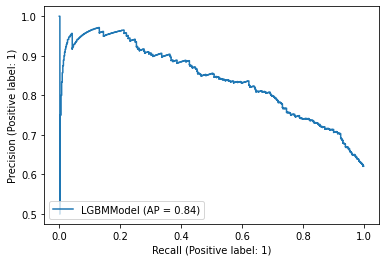

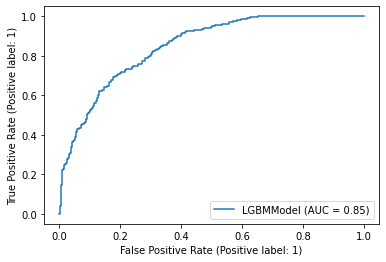

In [109]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
plot_precision_recall_curve(clf, pd.DataFrame(x_test), y_test)
plot_roc_curve(clf, pd.DataFrame(x_test), y_test)

In [ ]:
print_feature(x_att[:,-2], y)

In [ ]:
clf.feature_importances_